# WDSR (Wide Activation for Efficient and Accurate Image Super-Resolution)
### Model Architecture

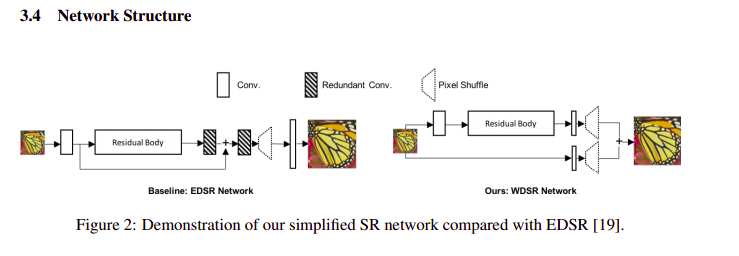

# Create WDSR Architecture

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
#import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.data.experimental import AUTOTUNE
import tensorflow_addons as tfa
import numpy as np
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Add, Conv2D, Input, Lambda
import tensorflow_probability as tfp
os.chdir('/content/drive/MyDrive/CS2')

In [ ]:
!ls

blur.jpeg	   CS2_EDA.ipynb       postprocess_gaussianblur.jpg  test.png
blur.png	   edsr_300000.h5      preprocessing.ipynb	     WDSR.ipynb
blurred-image.png  edsr_350000.h5      real_world_blur
checkpoint	   edsr_unknown_x4.h5  sumit_blur.jpg


In [ ]:
#policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
#tf.keras.mixed_precision.experimental.set_policy(policy) 

### Helper Functions

In [ ]:
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255
def normalize(x,rgb_mean=DIV2K_RGB_MEAN):
    '''This function will normalize image by substracting RGB mean from image'''
    return (x - rgb_mean) / 127.5

def denormalize(x,rgb_mean=DIV2K_RGB_MEAN):
    ''' This function will denormalize image by adding back rgb_mean'''
    return (x * 127.5 )+ rgb_mean

def shuffle_pixels(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

In [ ]:
#tf.keras.backend.set_floatx('float16')

In [ ]:
# Weight normalization as considered in WDSR paper
def conv2d_weightnorm(filters, kernel_size, padding='same', activation=None, **kwargs):
    return tfp.layers.weight_norm.WeightNorm(Conv2D(filters, kernel_size, padding=padding,
                                                 activation=activation, **kwargs), 
                                             data_init=False)

# WDSR Architecture

def WDSR(scale, num_filters, num_res_blocks, res_block_expansion, res_block_scaling, res_block):

    '''scale ==> It use at the end of residual blocks for slim mapping and also use in 
    original input to make size same as residual block output and then add it'''

    '''num_filters ==> Number of filters in conv of residual block '''

    '''res_block_expansion ==> a slim identity mapping pathway with wider (2× to 4×) channels 
    before activation in each residual block.'''

    '''res_block_scaling ==> whether you can to scale residual block or not'''

    '''res_block ==> use res_block_a for WDSR-A and res_block_b for WDSR-B network'''

    x_input = Input(shape=(None, None, 3))
    x = Lambda(normalize)(x_input)

    # main branch
    main_branch = conv2d_weightnorm(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        main_branch = res_block(main_branch, num_filters, res_block_expansion, kernel_size=3, scaling=res_block_scaling)
    main_branch = conv2d_weightnorm(3 * scale ** 2, 3, padding='same', name=f'conv2d_main_scale_{scale}')(main_branch)
    main_branch = Lambda(shuffle_pixels(scale))(main_branch)

    # skip branch
    s = conv2d_weightnorm(3 * scale ** 2, 5, padding='same', name=f'conv2d_skip_scale_{scale}')(x)
    s = Lambda(shuffle_pixels(scale))(s)

    x = Add()([main_branch, s])
    x = Lambda(denormalize)(x)

    return Model(x_input, x, name="WDSR")


def res_block_a(x_in, num_filters, expansion, kernel_size, scaling):
    ''' This block is used in WDSR-A network'''
    x = conv2d_weightnorm(num_filters * expansion, kernel_size, padding='same', activation='relu')(x_in)
    x = conv2d_weightnorm(num_filters, kernel_size, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x


def res_block_b(x_in, num_filters, expansion, kernel_size, scaling):
    '''This block is used for WDSR-B network'''
    linear = 0.8
    x = conv2d_weightnorm(num_filters * expansion, 1, padding='same', activation='relu')(x_in)
    x = conv2d_weightnorm(int(num_filters * linear), 1, padding='same')(x)
    x = conv2d_weightnorm(num_filters, kernel_size, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x


def WDSR_A(scale, num_filters=32, num_res_blocks=8, res_block_expansion=4, res_block_scaling=None):
    ''' This function creates WDSR_A Architecture'''
    return WDSR(scale, num_filters, num_res_blocks, res_block_expansion, res_block_scaling, res_block_a)


def WDSR_B(scale, num_filters=32, num_res_blocks=8, res_block_expansion=6, res_block_scaling=None):
    ''' This function creates WDSR_B Architecture'''
    return WDSR(scale, num_filters, num_res_blocks, res_block_expansion, res_block_scaling, res_block_b)

In [ ]:
model = WDSR_B(scale=4,num_res_blocks=32)

In [ ]:
model.summary()

Model: "WDSR"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
weight_norm (WeightNorm)        (None, None, None, 3 929         lambda[0][0]                     
__________________________________________________________________________________________________
weight_norm_1 (WeightNorm)      (None, None, None, 1 6529        weight_norm[0][0]                
_______________________________________________________________________________________________

# Creat Training Class

In [ ]:
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
import time
import os

In [ ]:
os.makedirs('checkpoint/wdsr/',exist_ok=True)

In [ ]:
class Training_pipeline:
    def __init__(self, model, loss, learning_rate, checkpoint_directory='/checkpoint/wdsr'):
        # current time
        self.start = None
        # initialize loss
        self.loss = loss
        # checkpoint initialize
        self.checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                              psnr=tf.Variable(-1.0),
                                              ssim = tf.Variable(-1.0),
                                              optimizer=tf.keras.optimizers.Adam(learning_rate,epsilon=1e-08),
                                              model=model)
        # checkpoint manager initialize
        self.checkpoint_manager = tf.train.CheckpointManager(checkpoint=self.checkpoint,
                                                             directory=checkpoint_directory,
                                                             max_to_keep=3)
        # restore letest checkpoint
        self.restore()
        
    @property
    def model(self):
        return self.checkpoint.model

    def train_model(self, train_dataset, validation_dataset, steps, evaluate_every=1000, save_best_only=False):
        print('Training Started')
        # initilize mean metric
        loss_mean = tf.keras.metrics.Mean()
        # call heckpoint manager
        checkpoint_manager = self.checkpoint_manager
        # call checkpoint
        checkpoint = self.checkpoint

        self.start = time.perf_counter()
        
        # Iterating through train ds
        for lr, hr in tqdm(train_dataset.take(steps - checkpoint.step.numpy())):
            #print('running')
            # adding 1 to checkpoint step
            checkpoint.step.assign_add(1)
            # get step value
            step = checkpoint.step.numpy()
            # get loss 
            loss = self.training_step(lr, hr)
            # get mean loss
            loss_mean(loss)
            
            # evaluate at every 1000 steps
            if step % evaluate_every == 0:
                # get loss mean at every 1000 step
                loss_value = loss_mean.result()
                # reset loss mean object 
                loss_mean.reset_states()
                # Compute psnr on validation dataset
                psnr = self.get_psnr(validation_dataset)
                # Compute ssim on validaton dataset
                ssim = self.get_ssim(validation_dataset)
                # get total time duration
                duration = time.perf_counter() - self.start
                # print loss, psnr and duration
                print(f'{step}/{steps}: LOSS = {loss_value.numpy():.4f},PSNR = {psnr.numpy():3f}, SSIM = {ssim.numpy():3f},Time = ({duration:.2f}s)')

                
                if save_best_only and psnr <= checkpoint.psnr:
                    self.start = time.perf_counter()
                    # skip saving checkpoint, if psnr not improving
                    continue
                # If psnr improved then save 
                checkpoint.psnr = psnr
                # save checkpoint manager 
                checkpoint_manager.save()

                self.start = time.perf_counter()


    #@tf.function(experimental_relax_shapes=True)
    def training_step(self, lr, hr):
        with tf.GradientTape() as tape:
            # convert dtypes
            lr = tf.cast(lr, tf.float32)
            hr = tf.cast(hr, tf.float32)

            # get sr image from trained model
            sr = self.checkpoint.model(lr, training=True)
            # get loss value 
            get_loss_value = self.loss(hr, sr)

        gradients = tape.gradient(get_loss_value, self.checkpoint.model.trainable_variables)
        self.checkpoint.optimizer.apply_gradients(zip(gradients, self.checkpoint.model.trainable_variables))

        return get_loss_value


    # evaluate (get psnr value)
    def get_psnr(self, dataset):
        psnr_values = []
        for lr, hr in tqdm(dataset):
            # convert dtype to float32
            lr = tf.cast(lr, tf.float32)
            # get sr image from model
            sr = self.checkpoint.model(lr)
            # clip values to 0,255
            sr = tf.clip_by_value(sr, 0, 255)
            # round up values
            sr = tf.round(sr)
            # change dtype to unint8
            sr = tf.cast(sr, tf.uint8)
            # get psnr value
            psnr_value = tf.image.psnr(hr, sr, max_val=255)[0]
            # append psnr value
            psnr_values.append(psnr_value)
        return tf.reduce_mean(psnr_values)

    # get ssim on validation dataset
    def get_ssim(self,dataset):
        ssim_values = []
        for lr,hr in tqdm(dataset):
            # convert dtype to float32
            lr = tf.cast(lr, tf.float32)
            # get sr image from model
            sr = self.checkpoint.model(lr)
            # clip values to 0,255
            sr = tf.clip_by_value(sr, 0, 255)
            # round up values
            sr = tf.round(sr)
            # change dtype to unint8
            sr = tf.cast(sr, tf.uint8)
            # get ssim value
            ssim_value = tf.image.ssim(hr, sr, max_val=255).numpy()[0]
            # append ssim value
            ssim_values.append(ssim_value)
        return tf.reduce_mean(ssim_values)

    # restore checkpoint
    def restore(self):
        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print(f'Model restored from checkpoint at step {self.checkpoint.step.numpy()}.')

## WDSR Trainer Class

In [ ]:
class WdsrTraining(Training_pipeline):
    def __init__(self,
                 model,
                 checkpoint_dir,
                 learning_rate=PiecewiseConstantDecay(boundaries=[200000], 
                                                      values=[1e-3, 5e-4])):

        super().__init__(model, 
                         loss=tf.keras.losses.MeanAbsoluteError(), 
                         learning_rate=learning_rate, 
                         checkpoint_directory=checkpoint_dir)

    def start_training(self, train_dataset, valid_dataset, steps=300000, evaluate_every=1000, save_best_only=True):
        super().train_model(train_dataset, valid_dataset, steps, evaluate_every, save_best_only)


# Get Training Data using tfds dataset
# DIV2k Bicubic_X4

In [ ]:
div2k = tfds.image.Div2k(config='bicubic_x4')
div2k.download_and_prepare()

In [ ]:
ds_train = div2k.as_dataset(split='train',as_supervised=True)
ds_valid = div2k.as_dataset(split='validation',as_supervised=True)

In [ ]:
d_train = ds_train.cache()
d_valid = ds_valid.cache()

In [ ]:
print('Train Cardinality of bicubic_x4 is ==> ',d_train.cardinality().numpy())
print('Validation Cardinality of bicubic_x4 is ==> ',d_valid.cardinality().numpy())

Train Cardinality of bicubic_x4 is ==>  800
Validation Cardinality of bicubic_x4 is ==>  100


In [ ]:
# -----------------------------------------------------------
#  Augmentation (crop, flip, rotate)
# -----------------------------------------------------------

def random_crop(lr_img, hr_img, hr_crop_size=96, scale=2):
    ''' This function crops lr(47x47) and hr(96x96) images'''
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_width = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_height = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_width = lr_width * scale
    hr_height = lr_height * scale

    lr_img_cropped = lr_img[lr_height:lr_height + lr_crop_size, lr_width:lr_width + lr_crop_size]
    hr_img_cropped = hr_img[hr_height:hr_height + hr_crop_size, hr_width:hr_width + hr_crop_size]

    return lr_img_cropped, hr_img_cropped

def random_flip(lr_img, hr_img):
    ''' This function will flip imag left_right randomly'''
    random = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(random < 0.5,lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))
        
def random_rotate(lr_img, hr_img):
    ''' This function will rotate image randomly to 90 degree'''
    rand = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rand), tf.image.rot90(hr_img, rand)

# Preprocessing (Crop(96 X 96 from HR and 24 X 24 from LR) , Flip, Rotate)

In [ ]:
def preprocessing(data, batch_size=16,scale=4,repeat_count=None,
                  crop_size=None,random_transform=True):
    # random transform will apply only on train dataset
    if random_transform:
        # random cropping
        data = data.map(lambda lr, hr:
                        random_crop(lr, hr, scale=scale,hr_crop_size=crop_size),
                        num_parallel_calls=AUTOTUNE)
        # random rotate
        data = data.map(random_rotate,num_parallel_calls=AUTOTUNE)
        # random flip
        data = data.map(random_flip,num_parallel_calls=AUTOTUNE)
    # ds.batch() will take images in given batch size
    data = data.batch(batch_size)
    # it will repeat dataset. if repeat_count() = None then infinite cardinality
    data = data.repeat(repeat_count)
    # ds.prefetch() will prefetch data for given buffer_size
    data = data.prefetch(buffer_size=AUTOTUNE)
    return data

In [ ]:
train_preprocessed = preprocessing(d_train,crop_size = 96)
valid_preprocessed = preprocessing(d_valid,batch_size=1,
                                   repeat_count=1,random_transform=False)

In [ ]:
print('Train preprocesssed Cardinality of bicubic_x4 is ==> ',
      train_preprocessed.cardinality().numpy())
print('Validation preprocessed Cardinality of bicubic_x4 is ==> ',
      valid_preprocessed.cardinality().numpy())

Train preprocesssed Cardinality of bicubic_x4 is ==>  -1
Validation preprocessed Cardinality of bicubic_x4 is ==>  100


In [ ]:
# This function will plot LR and HR images
def plot_sample(lr, sr,figsize=(10,10)):
    plt.figure(figsize=figsize)

    images = [lr, sr]
    titles = ['LR', 'HR']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

## Plot LR and HR images from preprocessed train data

In [ ]:
for lr, hr in train_preprocessed.take(3):
    print('LR Shape = {} and HR Shape = {}'.format(lr.shape,hr.shape))
    plot_sample(lr[0],hr[0])

# Start  Training

In [ ]:
trainer = WdsrTraining(
    model=WDSR_B(scale=4, num_res_blocks=32), 
    checkpoint_dir= f'checkpoint/wdsr')

In [ ]:
trainer.start_training(train_preprocessed,
              valid_preprocessed.take(10),
              steps=300000, 
              evaluate_every=1000, 
              save_best_only=True)

## Resume Training

In [ ]:
class WdsrTraining(Training_pipeline):
    def __init__(self,
                 model,
                 checkpoint_dir,
                 learning_rate=PiecewiseConstantDecay(boundaries=[290000], 
                                                      values=[25e-5, 125e-6])):

        super().__init__(model, 
                         loss=tf.keras.losses.MeanAbsoluteError(), 
                         learning_rate=learning_rate, 
                         checkpoint_directory=checkpoint_dir)

    def start_training(self, train_dataset, valid_dataset, steps=300000, evaluate_every=1000, save_best_only=True):
        super().train_model(train_dataset, valid_dataset, steps, evaluate_every, save_best_only)

In [ ]:
trainer = WdsrTraining(
    model=WDSR_B(scale=4, num_res_blocks=32), 
    checkpoint_dir= f'checkpoint/wdsr')

Model restored from checkpoint at step 300000.


In [ ]:
trainer.start_training(train_preprocessed,
              valid_preprocessed.take(10),
              steps=300000, 
              evaluate_every=1000, 
              save_best_only=True)

In [ ]:
trainer.restore()

Model restored from checkpoint at step 300000.


In [ ]:
# evaluate on whole validationn dataset
validation_psnr = trainer.get_psnr(valid_preprocessed)

In [ ]:
validation_ssim = trainer.get_ssim(valid_preprocessed)

In [ ]:
print('Validation PSNR ===> ', validation_psnr.numpy())
print('Validation SSIM ===> ', validation_ssim.numpy())

Validation PSNR ===>  28.944609
Validation SSIM ===>  0.8177277


In [ ]:
# save weights
trainer.model.save_weights('wdsr_300000.h5')

In [ ]:
model = WDSR_B(scale=4,num_res_blocks=32)
model.load_weights('wdsr_300000.h5')

# Helper functions to plot Original and predicted images

In [ ]:
from PIL import Image

def load_image(path):
    return np.array(Image.open(path))

def plot_images(lr,sr,hr,figsize = (20,10)):
    fig,axes = plt.subplots(nrows = 1, ncols = 3, figsize=figsize)
    for ax in axes.flatten():
        ax.axis('off')
    axes[0].set_title('Low resolution',fontdict={'fontsize': 20,'fontweight': 'bold'})
    axes[0].imshow(lr)
    axes[1].set_title('Super Resolution(predicted)',fontdict={'fontsize': 20,'fontweight': 'bold'})
    axes[1].imshow(sr)
    axes[2].set_title('High Resolution(Original)',fontdict={'fontsize': 20,'fontweight': 'bold'})
    axes[2].imshow(hr)

def get_sr_image(model, lr_batch):
    if len(lr_batch.shape) == 3 :
        lr_batch = tf.expand_dims(lr_batch,axis=0)
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch

In [ ]:
test_valid = preprocessing(d_valid.take(5),batch_size=1,repeat_count=1,random_transform=True,crop_size=96)    

In [ ]:
for lr,hr in test_valid:
    sr = get_sr_image(model,lr)
    psnr = tf.image.psnr(hr,sr,max_val=255).numpy()
    ssim = tf.image.ssim(hr,sr,max_val=255).numpy()
    print('PSNR = {} and SSIM = {}'.format(psnr,ssim))
    plot_images(lr[0],sr[0],hr[0])

In [ ]:
for lr,hr in valid_preprocessed.take(4):
    sr = get_sr_image(model,lr)
    psnr = tf.image.psnr(hr,sr,max_val=255).numpy()[0]
    ssim = tf.image.ssim(hr,sr,max_val=255).numpy()[0]
    print('PSNR = {} and SSIM = {}'.format(psnr,ssim))
    plot_images(lr[0],sr[0],hr[0],figsize=(20,20))

# Observation

* I have trained WDSR-B model on Bicubic with scale 4 downgraded images with 300000 steps.
* After 300000 steps PSNR on whole validation dataset  29. 
So i have trained EDSR model for total 360000 steps.
I have used Adam optimizer with initial learning rate 0.0001 for first 200000 steps. After that learning rate decresed by half so from step 200000 to 300000 learning rate was 5e-5.
from 300000 to 360000 learning rate decreased by half till 325000 and so on.
Model has been evaluated at every 1000 steps with first 10 images of validation dataset.
At every 1000 steps Average loss , Average PSNR and Average SSIM has been printed to observe model performance.
Final Model gives PSNR = 28.88 on Full validation dataset .